# 3. Markov Chain Monte Carlo

## 3.1 Key Concepts

The Metropolis-Hastings algorithm is a Markov Chain Monte Carlo (MCMC) method for obtaining a sequence of random samples from a probability distribution (target distribution) for which direct sampling is difficult. Since we obtain realisations of a Markov chain, we first give some information on Markov chains in general.

Let $(\Omega,\mathcal{A}, \mathbb{P})$ be some probability space and $\mathcal{H}$ a hilbert space.

**Definition (Markov Chain):** A Markov Chain in $\mathcal{H}$ is a sequence of $\mathcal{H}$-valued random variables $X_j: \Omega \rightarrow \mathcal{H}$ satisfying the Markov property, i.e.,

\begin{equation}
\mathbb{P}(X_{j+1} \in A | X_1,...,X_j) = \mathbb{P}(X_{j+1} \in A | X_j)
\end{equation}

for each $j\in \mathbb{N}$ and $A \in \mathcal{B}(\mathcal{H})$. The state $X_{j+1}$ only depends on the previous state $X_j$.

**Definition (Markov kernel):** We call a map $K: \mathcal{H} \times \mathcal{B}(\mathcal{H}) \rightarrow [0,1]$ transtition or Markov kernel if

* for all $x \in \mathcal{H}$ is $K(x,\cdot)$ a probability measure on $(\mathcal{H},\mathcal{B}(\mathcal{H}))$ and

* for all $A \in \mathcal{B}(\mathcal{H})$ is $K(\cdot, A)$ a measurable functional from $\mathcal{H}$ to $[0,1]$.

For our purpose we focus on finite dimensional $\mathcal{H}= \mathbb{R}^n$. Let $\mu$ be a probability measure on $\mathbb{R}^n$ with density $\mu(dx) \propto p(x) dx$.

**Definition (Proposal kernel):** Let $Q: \mathbb{R}^n \times \mathcal{B}(\mathbb{R}^n) \rightarrow [0,1]$ be a Markov kernel on $\mathbb{R}^n$ with a transition density $q: \mathbb{R}^n \times \mathbb{R}^n \rightarrow [0,\infty)$ such that
\begin{equation}
Q(x,A) = \int_{A} q(x,x')dx'
\end{equation}
for all $A \in \mathcal{B}(\mathbb{R}^n)$. $Q$ is called the proposal kernel.

We can now define the Metropolis-Hastings algortihm which allows us to sample from the target distribution $\mu$.

## Metropolis-Hastings Algorithm

The Metropolis-Hastings algorithm:

**Input** Proposal kernel $Q$ with transition density $q$, initial distribution $\mu \in \mathcal{P}(\mathbb{R}^n)$.

**Output** Realisations $(x_j)_{j \in \mathbb{N}}$ of a Markov chain $(X_j)_{j \in \mathbb{N}}$ 

1. Draw a realisation $x_1 \sim \mu$
2. **for** $j = 1, 2, \ldots$

    -Given the current state $X_j = x_j$, draw a realisation $x' \sim Q(x_j, \cdot)$ (proposal distribution)
    
    -Compute the acceptance probability
    \begin{equation}
    \alpha(x_j, x') := \min \left( 1, \frac{p(x') q(x_j, x')}{p(x_j) q(x', x_j)} \right).
    \end{equation}
    -Draw an independent sample $u_{j+1} \sim \mathcal{U}([0, 1])$ and set
    \begin{equation}
    x_{j+1} = \begin{cases} 
    x' & \text{if } u_{j+1} \leq \alpha(x_j, x'), \\
    x_j & \text{otherwise}.
    \end{cases}
    \end{equation}
3. **end for**

The choice of $\alpha$ guarantees that the Markov Chain $(X_1,..,X_n)$ has $\mu$ as its invariant measure. Since the proof is not relevant for later application, we omit it at this point.

First we note that for the calculation of the acceptance probability $\alpha$ we do not need to know the normalisation constant of the target distribution. Furthermore, the performance of the Metropolis-Hastings algorithm can be significantly influenced by the choice of the proposal distribution. In continuous state spaces, a commonly used proposal distribution is a Gaussian distribution centered on the current state.

### Example: Gaussian Random Walk

Let the proposal kernel $Q: \mathbb{R}^n \times \mathcal{B}(\mathbb{R}^n) \rightarrow [0,1]$ be chosen as follows 
\begin{equation}
Q(s;x,\cdot) = \mathcal{N}(x, s^2\mathbb{1}),
\end{equation}
where $s>0$ is a step size parameter. The transition density $q$ is given by
\begin{equation}
q(s;x,x') \propto exp\left(-\frac{1}{2s^2}\|x'-x\|^2\right)
\end{equation}

This introduces a trade-off in determing the variance parameter $s^2$ of the distribution. If the variance is small, the algorithm will have a high acceptance rate for transitions, but the exploration of the state space will proceed slowly in a manner similar to a random walk, resulting in long correlation times. If the variance parameter is large, the rejection rate will be high. The step size can be optimised or calibrated.

For the programming example we fix the dimension to $n=2$ and the step size for simplicity to $s=1$.

Iteration  Proposed x                Accepted   u          alpha     
0          [0.24731196 1.69549579]   False      0.36475    0.18680   
1          [ 0.64582609 -0.24362707] True       0.15645    0.65539   
2          [ 0.9157655  -0.85557309] True       0.19842    0.31762   
3          [ 1.44457999 -0.99161505] False      0.83552    0.23876   
4          [ 0.63079176 -0.60361692] True       0.07970    1.00000   
5          [0.46263288 0.63215569]   True       0.10351    1.00000   
6          [ 0.51929003 -0.21112926] True       0.26759    0.93384   
7          [-1.05425208  0.61415633] False      0.99729    0.31934   
8          [-1.55661602 -0.72890581] False      0.78253    0.39433   
9          [ 2.0310056  -0.26036805] False      0.76441    0.05698   


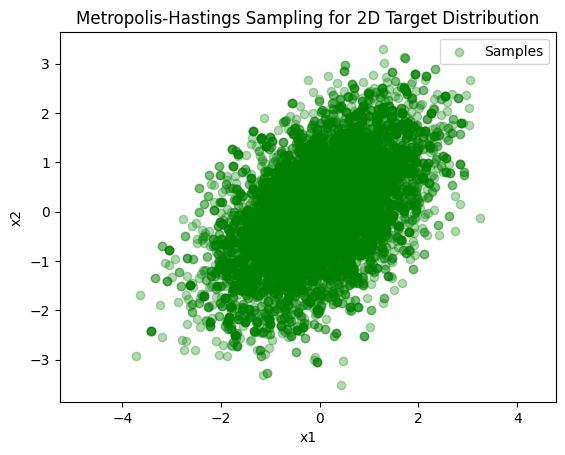

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import arviz as az

# Define the 2-dimensional target (posterior) distribution p(x)
def target_distribution(x):
    mean = np.array([0, 0])  # Mean of the bivariate normal distribution
    cov = np.array([[1, 0.5], [0.5, 1]])  # Covariance matrix of the bivariate normal distribution
    return multivariate_normal.pdf(x, mean, cov)

# Define the proposal distribution Q(x|y) - Gaussian proposal centered on the current state
def proposal_distribution(x):
    return np.random.multivariate_normal(x, np.eye(2))  # Multivariate normal centered at x with identity covariance

# Metropolis-Hastings algorithm
def metropolis_hastings(initial_state, num_samples, target_distribution, proposal_distribution):
    samples = []  # List to store the samples
    x = initial_state  # Start from the initial state
    acceptances = []
    
    for j in range(num_samples):
        # Given the current state x_j = x, draw a realization x' from Q(x, .)
        x_prime = proposal_distribution(x)
        
        # Compute the acceptance probability α(x, x')
        alpha = min(1, target_distribution(x_prime) / target_distribution(x))
        
        # Draw an independent sample u_j+1 ~ uniform[0, 1]
        u = np.random.uniform(0, 1)
        
        if u <= alpha:
            x = x_prime  # Accept the new state
            accepted = True
        else:
            accepted = False

        samples.append(x)  # Store the current state (whether accepted or not)

        # Store acceptance info for the first 10 iterations
        if j < 10:
            acceptances.append((x_prime, accepted, u, alpha))

    return np.array(samples), acceptances

# Parameters
initial_state = np.array([0, 0])
num_samples = 10000

# Run Metropolis-Hastings algorithm
samples, acceptances = metropolis_hastings(initial_state, num_samples, target_distribution, proposal_distribution)

# Print acceptance info for the first 10 iterations
print(f"{'Iteration':<10} {'Proposed x':<25} {'Accepted':<10} {'u':<10} {'alpha':<10}")
for i, (x_prime, accepted, u, alpha) in enumerate(acceptances):
    print(f"{i:<10} {str(x_prime):<25} {str(accepted):<10} {u:<10.5f} {alpha:<10.5f}")

# Plot samples
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.3, color='g', label='Samples')
plt.title('Metropolis-Hastings Sampling for 2D Target Distribution')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.axis('equal')
plt.show()

In the table we see the proposed values of $x$, if its accepted, the value of $u$ and the value of $\alpha$ for the first ten iterations. The plot shows the accepted samples. We see the shape of the 2-dimensional target (posterior) distribution that is a multivariate gaussian distribution with mean vector $[0, 0]$ and variance-covariance matrix $\small{\begin{pmatrix} 1 & 0.5 \\ 0.5 & 1 \end{pmatrix}}$.

For the next plots we use the python package `arviz` to illustrate in more detail the algorithm steps. The trace plot shows (left) for each coordinate the proposal densitiy (gaussian) and (right) the exploration of the sample space, i.e. the iteration number on the x-axis and the value on the y-axis. The pair plot shows the proposal distribution for the actual 2-dimensional target. As before the shape is determined by the variance-covariance matrix.

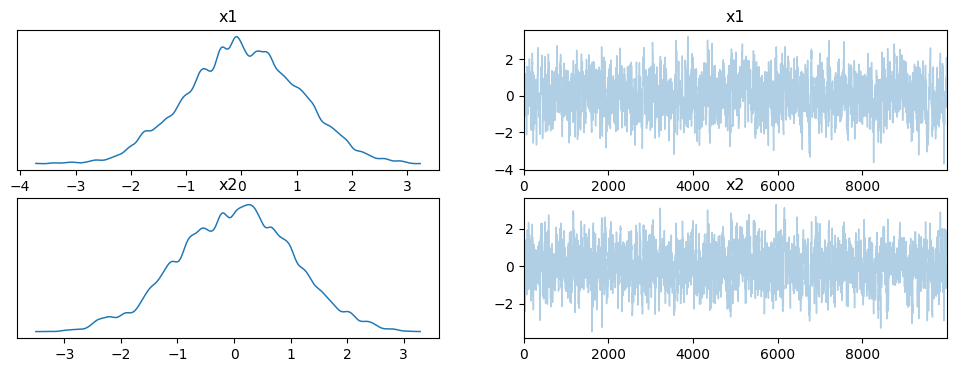

In [79]:
# Use ArviZ to create an InferenceData object
az_data = az.from_dict(posterior={'x1': samples[:, 0], 'x2': samples[:, 1]})

# Plot the results using ArviZ
az.plot_trace(az_data)
plt.show()

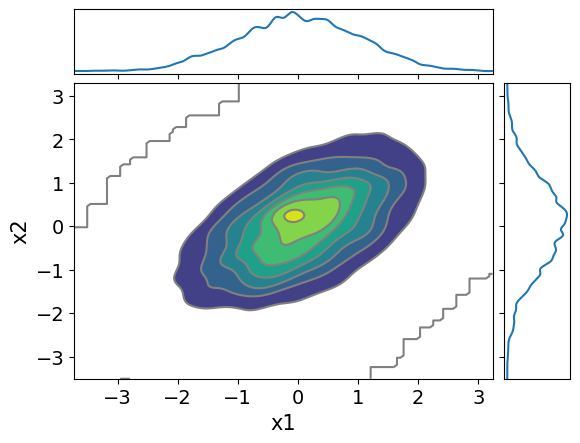

In [80]:
# Plot the posterior pairplot using ArviZ
az.plot_pair(az_data, kind='kde', marginals=True)
plt.show()

The following posterior plots show the estimated posterior density for first (left) and second coordinate (right). Furthermore the mean values and the credible intervals (HDI) are given.

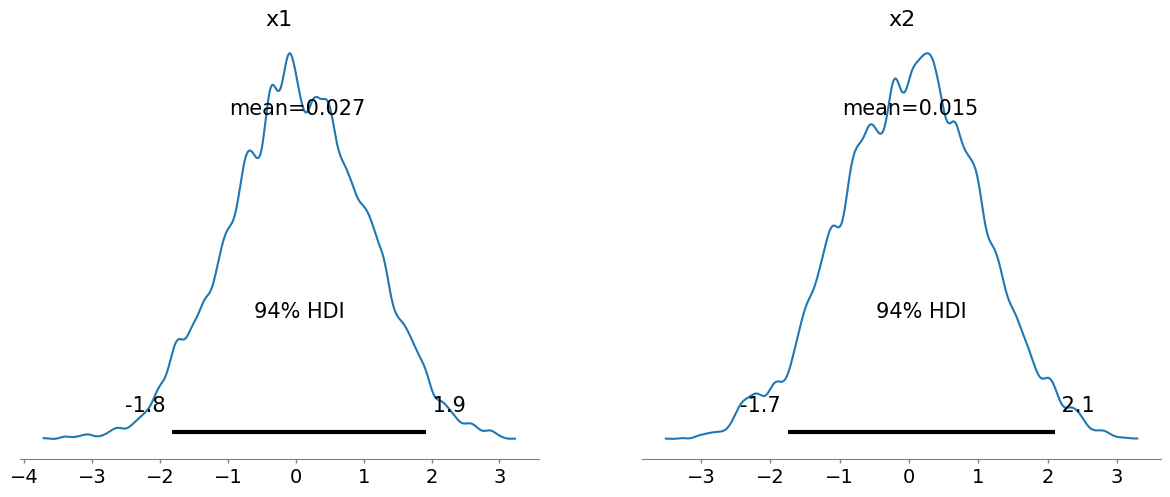

In [81]:
# Plot the posterior density using ArviZ
az.plot_posterior(az_data)
plt.show()

The next plot shows the autocorrelation of samples. The y-axis represents the autocorrelation coefficient, which ranges from $-1$ to $1$. Values close to $1$ indicate high positive correlation, values close to $-1$ indicate high negative correlation and values around $0$ indicate no correlation.

The x-axis in the autocorrelation plot represents the lag, which is the number of steps back between the data points being compared. A fast decay to 0 indicates good mixing and low correlation between successive samples. A slow decay indicates high correlation between samples, suggesting that the Markov Chain is not mixing well and more samples or better sampling strategies might be needed.

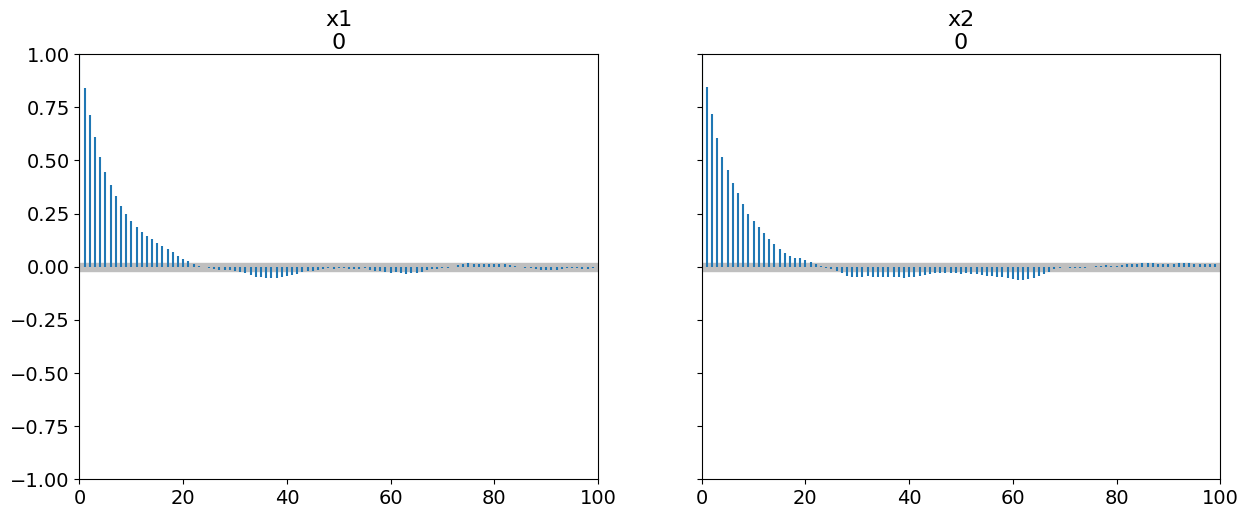

In [82]:
# Plot the autocorrelation of the samples
az.plot_autocorr(az_data, max_lag=100)#
plt.show()

#### Remark: 
Instead of implementing the Metropolis-Hastings algorithm by hand, one can use the python package `pymc`. Generating samples for our example can look like this:

```python
import numpy as np
import pymc as pm

# Define the 2-dimensional target (posterior) distribution p(x) using PyMC
with pm.Model() as model:
    # Define the multivariate normal distribution
    mean = np.array([0, 0])
    cov = np.array([[1, 0.5], [0.5, 1]])
    mvn = pm.MvNormal("mvn", mu=mean, cov=cov, shape=2)
    
    # Use Metropolis-Hastings sampler
    step = pm.Metropolis()
    
    # Sample from the posterior
    trace = pm.sample(10000, step=step, tune=10000, return_inferencedata=True)

# Extract samples from the trace
samples = trace.posterior['mvn'].stack(samples=("chain", "draw")).values.T
```